# Board Game Recommender - Data Story

Within this notebook, interesting trends in the data are examined for consideration later when building predictive models around the data.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.style.use('seaborn')

In [2]:
game_df = pd.read_json('bgg_database.json')

In [3]:
game_df.index.name = 'gameid'
game_df = game_df.reset_index().sort_values('rank')
game_df.head()

,gameid,attributes,average_rating,description,families,last_updated,name,num_voters,play_time,player_count,rank,ratings,weight,weighted_rating,year
1691,174430,"{u'boardgamedesigner': u'Isaac Childres', u'bo...",8.91228,Gloomhaven is a game of Euro-inspired tactica...,"[thematic, strategygames]",Mon Mar 18 23:34:48 2019,Gloomhaven,23504,120,"{u'1': {u'Recommended': u'267', u'Not Recommen...",1,"{u'pinbot': u'9', u'ladenedge': u'10', u'thesp...",3.7753,8.61315,2017
1344,161936,"{u'boardgamedesigner': u'Matt Leacock', u'boar...",8.64675,Pandemic Legacy is a co-operative campaign gam...,"[thematic, strategygames]",Mon Mar 18 22:47:26 2019,Pandemic Legacy: Season 1,30370,60,"{u'1': {u'Recommended': u'63', u'Not Recommend...",2,"{u'jocar84': u'9.5', u'horgboth': u'9', u'DerS...",2.8318,8.49226,2015
1903,182028,"{u'boardgamedesigner': u'Vlaada Chvátil', u'bo...",8.54243,Through the Ages: A New Story of Civilization ...,[strategygames],Tue Mar 19 00:58:33 2019,Through the Ages: A New Story of Civilization,15179,120,"{u'1': {u'Recommended': u'5', u'Not Recommende...",3,"{u'the_ka': u'8', u'jmwillis5': u'9.37', u'Doe...",4.3657,8.26341,2015
1489,167791,"{u'boardgamedesigner': u'Jacob Fryxelius', u'b...",8.40232,"In the 2400s, mankind begins to terraform the ...",[strategygames],Mon Mar 18 21:30:17 2019,Terraforming Mars,36736,120,"{u'1': {u'Recommended': u'434', u'Not Recommen...",4,"{u'AkeTharus': u'10', u'jocar84': u'9', u'andi...",3.2313,8.23708,2016
377,12333,"{u'boardgamedesigner': u'Jason Matthews', u'bo...",8.32508,"&quot;Now the trumpet summons us again, not as...","[wargames, strategygames]",Mon Mar 18 22:47:26 2019,Twilight Struggle,33857,180,"{u'1': {u'Recommended': u'22', u'Not Recommend...",5,"{u'wooda': u'8', u'andi1977': u'10', u'Elirirz...",3.5645,8.17631,2005


In [4]:
ratings_df = pd.read_json('ratings.json')

In [5]:
ratings_df.head()

,gameid,score,user
0,174430,9.00,pinbot
1,174430,10.00,ladenedge
10,174430,7.00,iltsu
100,174430,9.55,Cooptah
1000,174430,10.00,igomin


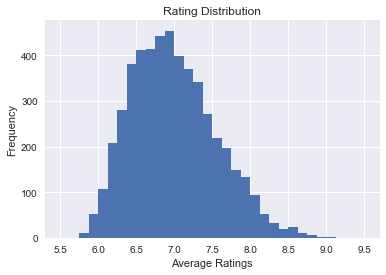

In [6]:
game_df.hist('average_rating', bins = np.linspace(5.5, 9.5, 33))
plt.xlabel('Average Ratings')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

The ratings distribution is plotted above for the top 5000 games on BGG; the ratings appear to be right-skewed.  It is very likely that the average ratings distribution would be more symmetric with the inclusions of ratings of all games, but it is also likely that the skew is due to other factors.  Perhaps users are hesitant to give very low scores or perhaps very low-quality games never had enough popularity for users to vote on them.

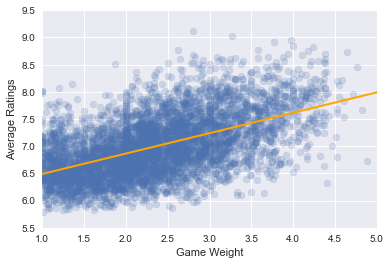

In [7]:
x = game_df.weight
y = game_df.average_rating

slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_pred = [1, 5]
y_pred = [x_pt*slope+intercept for x_pt in x_pred]

plt.scatter(x, y, alpha=0.2)
plt.plot(x_pred, y_pred, 'orange', linewidth=2)
plt.axis([1,5,5.5,9.5])
plt.xlabel('Game Weight')
plt.ylabel('Average Ratings')
plt.show()

Now some visualizations of trends in the data are performed to identify possible predictors for ratings.  The 'weight' of the game is a user-voted value between 1 and 5 that describes how complex a game is to learn and play.  The scatter plot above demonstrates that there is a positive trend of higher weight games scoring higher average ratings.

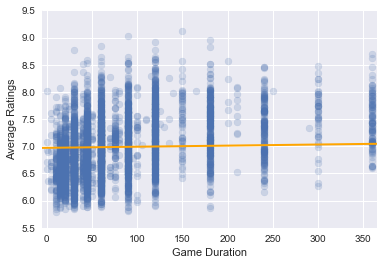

In [8]:
x = game_df.play_time
y = game_df.average_rating

slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_pred = [-5, 365]
y_pred = [x_pt*slope+intercept for x_pt in x_pred]

plt.scatter(game_df.play_time, game_df.average_rating, alpha=0.2)
plt.plot(x_pred, y_pred, 'orange', linewidth=2)
plt.axis([-5, 365, 5.5, 9.5])
plt.xlabel('Game Duration')
plt.ylabel('Average Ratings')
plt.show()

Game length may also be an important factor, as some player may dislike games that are several hours long.  However, there is no clear trend here; it would seem duration of a game does not have a substantial effect on rating.

Lastly, the type of game is considered.  The classes of game types that each game belongs to are stored in the game_df dataframe as lists.  Each game can belong to 0 or more families, but it should be noted that these are manually assigned by the users that create the database entries for the games, so the class assignments are somewhat subjective.  Nevertheless, these category assignments should provide a rough way to divide the games into groups of similar games.

The first steps for this analysis involve pulling the lists from the dataframe and reorganizing them into a wide-form dataframe.

In [9]:
game_families = []
for index, row in game_df.iterrows():
    for family in row.families:
        game_families.append((row.gameid,family,1))

In [10]:
family_df = pd.DataFrame(game_families, columns=['gameid','family','value'])
family_df = family_df.pivot(index='gameid', columns='family', values='value')
family_df = family_df.fillna(0).reset_index()
family_df.head()

family,gameid,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,wargames
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The ratings from game_df can then be merged into this dataframe matching the 'gameid' columns.

In [11]:
family_df = family_df.merge(game_df[['gameid','average_rating']], how='left', left_on='gameid', right_on='gameid')
family_df.head()

,gameid,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,wargames,average_rating
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.63445
1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.62159
2,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.43872
3,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.35338
4,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.50756


Here, the counts for each family are displayed.

In [12]:
family_df[['abstracts','cgs','childrensgames','familygames','partygames','strategygames','thematic','wargames']].sum()

abstracts          246.0
cgs                116.0
childrensgames      92.0
familygames       1180.0
partygames         306.0
strategygames     1542.0
thematic           713.0
wargames           799.0
dtype: float64

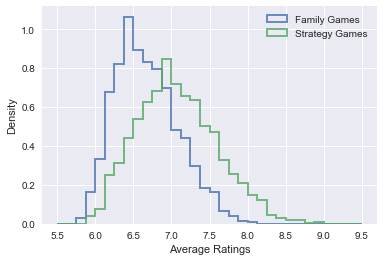

In [13]:
plt.hist(family_df[family_df.familygames==1]['average_rating'], bins=np.linspace(5.5, 9.5, 33), density=1, histtype='step', linewidth=2, alpha=0.8)
plt.hist(family_df[family_df.strategygames==1]['average_rating'], bins=np.linspace(5.5, 9.5, 33), density=1, histtype='step', linewidth=2, alpha=0.8)
plt.xlabel('Average Ratings')
plt.ylabel('Density')
plt.legend(['Family Games', 'Strategy Games'])
plt.show()

For comparison, the 2 most common classes (family and strategy games) are plotted against each other.  The mean rating for strategy games appears to be higher than for family games.

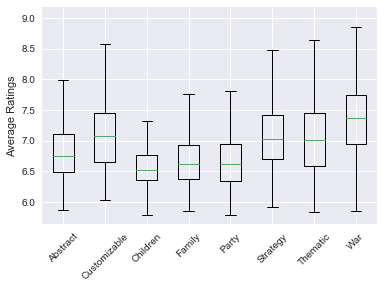

In [14]:
plt.boxplot([family_df[family_df.abstracts==1]['average_rating'],
             family_df[family_df.cgs==1]['average_rating'],
             family_df[family_df.childrensgames==1]['average_rating'],
             family_df[family_df.familygames==1]['average_rating'],
             family_df[family_df.partygames==1]['average_rating'],
             family_df[family_df.strategygames==1]['average_rating'],
             family_df[family_df.thematic==1]['average_rating'],
             family_df[family_df.wargames==1]['average_rating']],
            labels=['Abstract', 'Customizable', 'Children', 'Family', 'Party', 'Strategy', 'Thematic', 'War'])
plt.ylabel('Average Ratings')
plt.xticks(rotation=45)
plt.show()


This box plot helps to compare the ratings distributions for each family of game.  In general, children's games have the lowest ratings and wargames have the highest.

While all of the above factors could be used in predicting board game ratings, collaborative filtering involves predicting a user's ratings utilizing the ratings of other users as features for prediction.  This data exploration will be continued in notebook bgg-data-interactive